In [1]:
import os
import torch
import numpy as np
import umap
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import Pk_library as PKL
import os
os.environ["PATH"] += ':/mnt/sw/nix/store/2h2mfxgy98zls6ja0czcz087i38v8wx3-texlive-20240312/bin/x86_64-linux'

import importlib
import matplotlib.pyplot as plt

importlib.reload(plt)

from module import FlowMatchingModel

import scienceplots
plt.style.use('science')

from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

def get_pk(delta):
    BoxSize = 25  
    MAS     = 'None'  
    threads = 1   
    axis    = 0
    # delta = (delta-delta.mean()) / delta.std()
    pk = PKL.Pk(delta,BoxSize,axis, MAS,threads,verbose=False)
    # print(np.asarray(pk.k).max())
    return pk.k1D, pk.Pk1D

def get_xcorr(delta1, delta2):
    BoxSize = 25
    threads = 1
    axis    = 0
    delta1 = (delta1-delta1.mean())/delta1.std()
    delta2 = (delta2-delta2.mean())/delta2.std()
    Pk = PKL.XPk([delta1,delta2], BoxSize, axis, MAS=['CIC','CIC'], threads=1)
    return Pk.k1D, Pk.PkX1D[:,0]  / np.sqrt(Pk.Pk1D[:,0] * Pk.Pk1D[:,1])

def load_model(checkpoint_path, device=None):
    """Load trained flow matching model from checkpoint"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FlowMatchingModel.load_from_checkpoint(checkpoint_path, map_location=device)
    model.to(device)
    model.eval()
    return model, device

/mnt/home/mliu1/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class ResNetEmbeddingExtractor:
    """
    Alternative extractor that directly extracts ResNet embeddings without 
    needing to run the full UNet forward pass
    """
    def __init__(self, checkpoint_path):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = FlowMatchingModel.load_from_checkpoint(checkpoint_path)
        self.model.to(self.device)
        self.model.eval()
        
    def extract_embeddings(self, total_mass, gas_maps, astro_params, batch_size=25):
        """
        Directly extract ResNet embeddings without running the full model
        """
        all_embeddings = []
        n_samples = len(total_mass)
        
        for i in range(0, n_samples, batch_size):
            end_idx = min(i + batch_size, n_samples)
            
            # Prepare target maps tensor
            target_maps = torch.FloatTensor(gas_maps[i:end_idx])
            
            with torch.no_grad():
                # Directly compute ResNet embeddings
                embeddings = self.model.resnet_branch(target_maps)
                all_embeddings.append(embeddings.detach().cpu().numpy())
            
            # Clear memory
            del target_maps
            torch.cuda.empty_cache()
        
        return np.vstack(all_embeddings) if all_embeddings else np.array([])
    
    def extract_custom_embeddings(self, custom_input, batch_size=25):
        """
        Extract embeddings from custom input tensors
        """
        all_embeddings = []
        n_samples = custom_input.shape[0]
        
        for i in range(0, n_samples, batch_size):
            end_idx = min(i + batch_size, n_samples)
            
            input_batch = torch.FloatTensor(custom_input[i:end_idx]).to(self.device)
            
            with torch.no_grad():
                embeddings = self.model.resnet_branch(input_batch)
                all_embeddings.append(embeddings.detach().cpu().numpy())
            
            del input_batch
            torch.cuda.empty_cache()
        
        return np.vstack(all_embeddings) if all_embeddings else np.array([])

In [4]:
import numpy as np
import torch
from typing import List, Dict, Tuple, Optional

class ResNetEmbeddingExtractor:
    """Helper class to extract embeddings from the ResNet branch"""
    def __init__(self, checkpoint_path):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        # Load the full model to access resnet_branch
        from module import FlowMatchingModel  # Update with actual import
        self.model = FlowMatchingModel.load_from_checkpoint(checkpoint_path)
        self.model.eval()
        self.model.to(self.device)
        
    def extract_embeddings(self, cdm_mass, gas_maps, vcdm_maps, cosmo_params, astro_params, batch_size=32):
        """Extract ResNet embeddings from gas maps"""
        all_embeddings = []
        n_samples = len(gas_maps)
        
        with torch.no_grad():
            for i in range(0, n_samples, batch_size):
                batch_gas = torch.tensor(
                    gas_maps[i:i+batch_size], 
                    dtype=torch.float32
                ).unsqueeze(1).to(self.device)  # Add channel dimension
                
                # Extract mean and std from ResNet branch
                resnet_output = self.model.resnet_branch(batch_gas)
                embed_mean = resnet_output[:, :8].cpu().numpy()
                
                all_embeddings.append(embed_mean)
        
        return np.vstack(all_embeddings) if all_embeddings else np.array([])


class AnalysisPipeline:
    """
    Unified pipeline for 3D flow matching model analysis
    """
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._load_model()

        # Initialize extractor
        self.extractor = ResNetEmbeddingExtractor(checkpoint_path)
        
        # Storage for loaded datasets
        self.loaded_datasets = {}
        self.all_features_resnet = []
        self.all_labels_resnet = []
        self.all_cosmo_params = []
        self.all_astro_params = []
        
    def _load_model(self):
        """Load the trained model"""
        from module import FlowMatchingModel  # Update with actual import
        model = FlowMatchingModel.load_from_checkpoint(self.checkpoint_path)
        model.eval()
        model.to(self.device)
        return model
    
    def load_model_data(self, model_name: str, dataset: str, n_samples: int = 500) -> Tuple:
        """Load and normalize 3D data following training pattern"""

        if model_name in ['EAGLE','Magneticum']:
            base_dir = '/mnt/home/mliu1/CAMELS-cube'
        else:
            base_dir = f'/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/3D_grids/data/{model_name}'
        
        # Load full 3D datasets
        cdm_mass = np.load(f'{base_dir}/Grids_Mcdm_{model_name}_{dataset}_128_z=0.0.npy',mmap_mode='r')
        gas_maps = np.load(f'{base_dir}/Grids_Mgas_{model_name}_{dataset}_128_z=0.0.npy',mmap_mode='r')
        vcdm_maps = np.load(f'{base_dir}/Grids_Vcdm_{model_name}_{dataset}_128_z=0.0.npy',mmap_mode='r')
        params = np.loadtxt(f'{base_dir}/params_{dataset}_{model_name}.txt')
        
        # Apply log1p transformation (training pattern)
        cdm_mass_log = np.log1p(cdm_mass)
        gas_maps_log = np.log1p(gas_maps)
        # vcdm_maps - no log transform
        
        # Load normalization statistics
        stat = np.load('../norm3d.npy', allow_pickle=True).item()
        cdm_mean, cdm_std = stat['dm']['mean'], stat['dm']['std']        
        vcdm_mean, vcdm_std = stat['vcdm']['mean'], stat['vcdm']['std']        
        gas_mean, gas_std = stat['gas']['mean'], stat['gas']['std']        
        
        # Sample if needed
        if len(cdm_mass_log) > n_samples:
            indices = [i in range(n_samples)]
            cdm_mass_log = cdm_mass_log[indices]
            gas_maps_log = gas_maps_log[indices] 
            vcdm_maps = vcdm_maps[indices]
            params = params[indices]
            
        # Normalize
        cdm_mass_norm = (cdm_mass_log - cdm_mean) / cdm_std
        gas_maps_norm = (gas_maps_log - gas_mean) / gas_std
        vcdm_maps_norm = (vcdm_maps - vcdm_mean) / vcdm_std
        
        # Split parameters
        cosmo_params = params[:, :2]
        astro_params = params[:, 2:] if params.shape[1] > 2 else np.zeros((len(params), 0))
        
        return cdm_mass_norm, gas_maps_norm, vcdm_maps_norm, cosmo_params, astro_params
    
    def extract_embedding(self, simulation_models: List[str], dataset: str = 'LH', 
                         n_samples: int = 500, extract_features: bool = True) -> Optional[np.ndarray]:
        """
        Process all simulation models: load data and optionally extract features
        
        Args:
            simulation_models: List of model names
            dataset: Dataset type ('LH', 'CV', etc.)
            n_samples: Number of samples to load per model
            extract_features: Whether to extract ResNet features
        """
        print("Processing simulation models...")
        
        for model_name in simulation_models:
            print(f"Loading {model_name}...")
            
            # Load data
            cdm_mass, gas_maps, vcdm_maps, cosmo_params, astro_params = self.load_model_data(
                model_name, dataset, n_samples=n_samples
            )
            print(f"  Loaded {len(cdm_mass)} samples")
            
            # Store loaded data
            self.loaded_datasets[model_name] = (cdm_mass, gas_maps, vcdm_maps, cosmo_params, astro_params)
            
            # Extract features if requested
            if extract_features:
                print(f"  Extracting embeddings...")
                features = self.extractor.extract_embeddings(
                    cdm_mass, gas_maps, vcdm_maps, cosmo_params, astro_params
                )
                
                if len(features) > 0:
                    self.all_features_resnet.append(features)
                    self.all_labels_resnet.extend([model_name] * len(features))
                    self.all_cosmo_params.append(cosmo_params)
                    self.all_astro_params.append(astro_params)
                    print(f"  Extracted {len(features)} embeddings")
        
        print(f"\nCompleted processing {len(simulation_models)} models")
        
        if extract_features and self.all_features_resnet:
            X_resnet_combined = np.vstack(self.all_features_resnet)
            print(f"Total extracted features: {X_resnet_combined.shape}")
            return X_resnet_combined
        
        return None
    
    def inference(self, cdm_mass: np.ndarray, vcdm_map: np.ndarray, params: np.ndarray, 
                  resnet_embed: Optional[np.ndarray] = None, 
                  resnet_input: Optional[np.ndarray] = None, 
                  num_steps: int = 100) -> np.ndarray:
        """
        Run inference with the flow matching model
        
        Args:
            cdm_mass: CDM mass field (D, H, W)
            vcdm_map: Velocity CDM field (D, H, W)
            params: Cosmological parameters (2,)
            resnet_embed: Pre-computed embedding (8,) - optional
            resnet_input: Gas map for computing embedding (D, H, W) - optional
            num_steps: Number of integration steps
        """
        # Prepare inputs
        if resnet_input is not None:
            resnet_input = torch.tensor(resnet_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(self.device)
        if resnet_embed is not None:
            resnet_embed = torch.tensor(resnet_embed, dtype=torch.float32).unsqueeze(0).to(self.device)
            
        cdm_mass = torch.tensor(cdm_mass, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(self.device)
        vcdm_map = torch.tensor(vcdm_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(self.device)
        params = torch.tensor(params, dtype=torch.float32).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            pred = self.model.sample(
                cdm_mass=cdm_mass,  
                vcdm_map=vcdm_map,
                cosmo_params=params,  
                embed=resnet_embed,
                resnet_input=resnet_input,  
                num_steps=num_steps,
                method='euler'
            ).cpu().numpy()[0, 0]  # Remove batch and channel dims
            
        return pred
    
    def five_samples(self, ids: List[int], num_steps: int = 100) -> Dict:
        """
        Generate multiple samples for uncertainty analysis
        
        Args:
            ids: List of indices for each model
            num_steps: Number of sampling steps
        """        
        if not self.loaded_datasets:
            raise ValueError("No datasets loaded. Run extract_embedding() first.")
            
        model_names = list(self.loaded_datasets.keys())
        
        # Initialize result containers
        preds_all, gas_true_all, cdm_all, vcdm_all, params_list_all = [], [], [], [], []
        dataset_labels = []

        # Process all datasets
        for i, model_name in enumerate(model_names):
            if i >= len(ids):
                print(f"Warning: No index provided for {model_name}, skipping...")
                continue
                
            idx = ids[i]
            cdm_mass, gas_maps, vcdm_maps, cosmo_params, astro_params = self.loaded_datasets[model_name]
            
            # Check if index is valid
            if idx >= len(cdm_mass):
                print(f"Warning: Index {idx} out of range for {model_name} (max: {len(cdm_mass)-1}), skipping...")
                continue
            
            print(f"Processing {model_name}, sample {idx}...")
            
            # Get the sample data (already normalized)
            sample_cdm = cdm_mass[idx]
            sample_gas = gas_maps[idx]
            sample_vcdm = vcdm_maps[idx]
            cosmo_params_sample = cosmo_params[idx]

            # Create noisy versions of CDM mass map for uncertainty estimation
            noisy_cdm_list = [
                sample_cdm + np.random.normal(loc=0, scale=0.1, size=sample_cdm.shape)
                for _ in range(5)
            ]

            # Process each noisy version
            for noisy_cdm in noisy_cdm_list:
                pred = self.inference(
                    cdm_mass=noisy_cdm,
                    vcdm_map=sample_vcdm,
                    params=cosmo_params_sample,
                    resnet_input=sample_gas,  # Use true gas map to compute embedding
                    num_steps=num_steps
                )

                # Store results
                preds_all.append(pred)
                gas_true_all.append(sample_gas)
                cdm_all.append(noisy_cdm)
                vcdm_all.append(sample_vcdm)
                params_list_all.append(cosmo_params_sample)
                dataset_labels.append(model_name)

        print(f"\nGenerated {len(preds_all)} total predictions")

        return {
            'preds_all': preds_all,
            'gas_true_all': gas_true_all,
            'cdm_all': cdm_all,
            'vcdm_all': vcdm_all,
            'params_list_all': params_list_all,
            'dataset_labels': dataset_labels,
            'model': self.model,
            'device': self.device
        }
    
    def sampling(self, ids: List[int], num_steps: int = 100) -> Dict:
        """Alias for five_samples for backward compatibility"""
        return self.five_samples(ids, num_steps)
    
    def get_combined_features(self) -> Optional[np.ndarray]:
        """Get the combined feature matrix"""
        if self.all_features_resnet:
            return np.vstack(self.all_features_resnet)
        return None
    
    def get_labels(self) -> List[str]:
        """Get the model labels"""
        return self.all_labels_resnet
    
    def get_parameters(self) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """Get cosmological and astrophysical parameters"""
        return self.all_cosmo_params, self.all_astro_params

In [5]:
# checkpoint_path = 'lightning_logs/newnew/checkpoints/best-model-epoch=143-val_loss=0.026560.ckpt'
# checkpoint_path = 'lightning_logs/newnewnew/checkpoints/best-model-epoch=458-val_loss=0.024681.ckpt'
import glob
import os

checkpoint_dir = 'lightning_logs/md1vsje5/checkpoints'
ckpt_files = glob.glob(os.path.join(checkpoint_dir, '*.ckpt'))
if ckpt_files:
    checkpoint_path = ckpt_files[0] 
    print(f"Found checkpoint: {checkpoint_path}")
    
simulation_models = ['IllustrisTNG', 'EAGLE', 'SIMBA', 'Astrid']

pipeline = AnalysisPipeline(checkpoint_path)

# Load data and extract features
trained_embed = pipeline.extract_embedding(simulation_models, dataset='LH', n_samples=1000)

Found checkpoint: lightning_logs/md1vsje5/checkpoints/best-model-epoch=70-val_loss=0.034041.ckpt
Processing simulation models...
Loading IllustrisTNG...
  Loaded 1000 samples
  Extracting embeddings...
  Extracted 1000 embeddings
Loading EAGLE...
  Loaded 1000 samples
  Extracting embeddings...
  Extracted 1000 embeddings
Loading SIMBA...
  Loaded 1000 samples
  Extracting embeddings...
  Extracted 1000 embeddings
Loading Astrid...
  Loaded 1000 samples
  Extracting embeddings...
  Extracted 1000 embeddings

Completed processing 4 models
Total extracted features: (4000, 8)


In [6]:
mag_resnet = pipeline.extract_embedding(['Magneticum'], dataset='LH', n_samples=1000)[4000:]

Processing simulation models...
Loading Magneticum...
  Loaded 48 samples
  Extracting embeddings...
  Extracted 48 embeddings

Completed processing 1 models
Total extracted features: (4048, 8)


In [7]:
from openTSNE import TSNE

tsne = TSNE(n_components=2, perplexity=30)
embedding_train = tsne.fit(trained_embed)
embedding_test  = embedding_train.transform(mag_resnet)


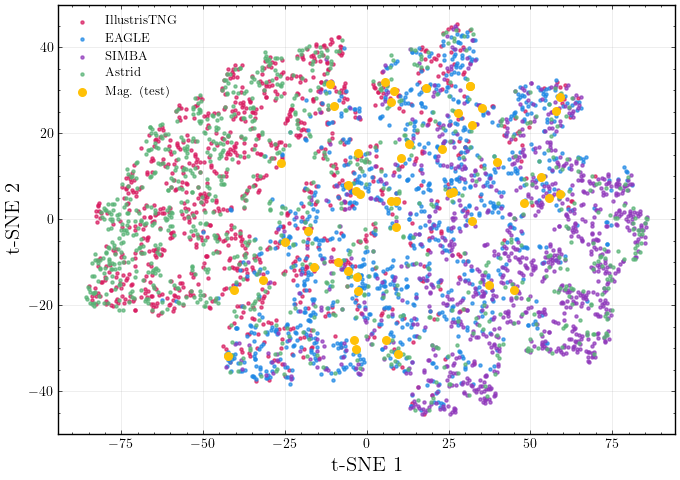

In [9]:
plt.figure(figsize=(7, 5))
colors = ['#D81B60','#1E88E5','#8F38BB','#57B375','#FFC107']
linex, liney = [],[]
sim_labels = pipeline.get_labels()

for i, model_name in enumerate(simulation_models):
    mask = [label == model_name for label in sim_labels]
    plt.scatter(embedding_train[mask[:4000], 0], embedding_train[mask[:4000], 1], marker='.',
               c=colors[i], label=model_name, alpha=.7, s=20)
plt.scatter(embedding_test[:,0],embedding_test[:,1],marker='o',c=colors[-1],label='Mag. (test)', alpha=1, s=30)
plt.xlabel('t-SNE 1',fontsize=15)
plt.ylabel('t-SNE 2',fontsize=15)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
# Make the frame thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(1)
plt.tight_layout()
plt.show()


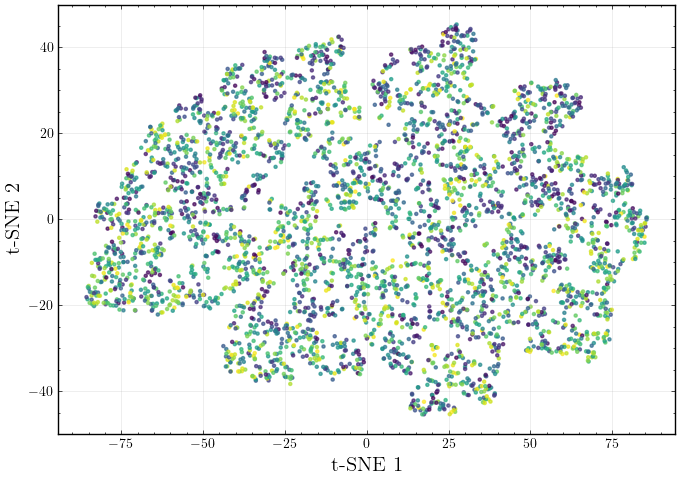

In [27]:
plt.figure(figsize=(7, 5))
cosmo_param, _ = pipeline.get_parameters()
colouring = np.concatenate(np.asarray(cosmo_param[:4]),axis=0)

for i, model_name in enumerate(simulation_models):
    mask = [label == model_name for label in sim_labels[:4000]]
    plt.scatter(embedding_train[mask, 0], embedding_train[mask, 1], marker='.',
               c=colouring[mask,1], label=model_name, alpha=.7, s=20)
# plt.scatter(embedding_test[:,0],embedding_test[:,1],marker='o',c=colors[-1],label='Mag. (test)', alpha=1, s=30)
plt.xlabel('t-SNE 1',fontsize=15)
plt.ylabel('t-SNE 2',fontsize=15)
# plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
# Make the frame thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(1)
plt.tight_layout()
plt.show()


In [28]:
pipeline_CV = AnalysisPipeline(checkpoint_path)
trained_embed_CV = pipeline_CV.extract_embedding(simulation_models, dataset='CV', n_samples=1000)

Processing simulation models...
Loading IllustrisTNG...
  Loaded 27 samples
  Extracting embeddings...
  Extracted 27 embeddings
Loading EAGLE...
  Loaded 27 samples
  Extracting embeddings...
  Extracted 27 embeddings
Loading SIMBA...
  Loaded 27 samples
  Extracting embeddings...
  Extracted 27 embeddings
Loading Astrid...
  Loaded 27 samples
  Extracting embeddings...
  Extracted 27 embeddings

Completed processing 4 models
Total extracted features: (108, 8)


In [29]:
import numpy as np

def interpolate_and_infer(pipeline, embedding_idx1, embedding_idx2, 
                         cdm_mass, vcdm_map, cosmo_params, num_steps=100, 
                         alpha_values=None):
    """
    Interpolate between two embeddings and generate predictions
    
    Args:
        pipeline: AnalysisPipeline instance
        embedding_idx1: Index of first embedding
        embedding_idx2: Index of second embedding
        cdm_mass: CDM mass field (D, H, W) - 3D array
        vcdm_map: Velocity CDM field (D, H, W) - 3D array
        cosmo_params: Cosmological parameters (2,)
        num_steps: Number of integration steps
        alpha_values: Interpolation weights (0=emb1, 1=emb2)
    
    Returns:
        List of dicts with 'alpha', 'prediction', 'interpolated_embedding'
    """
    if alpha_values is None:
        alpha_values = [0, 0.25, 0.5, 0.75, 1.0]
    
    # Get the combined features matrix
    X_resnet_combined = pipeline.get_combined_features()
    
    if X_resnet_combined is None:
        raise ValueError("No ResNet features found. Make sure extract_embedding() was run with extract_features=True")
    
    # Get the two embeddings to interpolate between
    embedding1 = X_resnet_combined[embedding_idx1]
    embedding2 = X_resnet_combined[embedding_idx2]
    
    print(f"Interpolating between embedding {embedding_idx1} and {embedding_idx2}")
    print(f"Embedding shapes: {embedding1.shape}, {embedding2.shape}")
    print(f"CDM mass shape: {cdm_mass.shape}")
    print(f"VCDM map shape: {vcdm_map.shape}")
    
    predictions = []
    
    for alpha in alpha_values:
        print(f"Running inference with alpha = {alpha:.2f}")
        
        # Linear interpolation: (1-alpha) * emb1 + alpha * emb2
        interpolated_embedding = (1 - alpha) * embedding1 + alpha * embedding2
        
        # Run inference with interpolated embedding
        # Updated to pass vcdm_map as required by new model
        pred = pipeline.inference(
            cdm_mass=cdm_mass,
            vcdm_map=vcdm_map,  # NEW: required for 3D model
            params=cosmo_params,
            resnet_embed=interpolated_embedding,
            num_steps=num_steps
        )
        
        predictions.append({
            'alpha': alpha,
            'prediction': pred,
            'interpolated_embedding': interpolated_embedding
        })
    
    print(f"Completed {len(predictions)} interpolation steps")
    return predictions


def get_embedding_info(pipeline):
    """
    Get information about extracted embeddings
    
    Args:
        pipeline: AnalysisPipeline instance
    
    Returns:
        Dict with embedding statistics and model indices, or None if no embeddings
    """
    X_resnet = pipeline.get_combined_features()
    labels = pipeline.get_labels()
    cosmo_params, astro_params = pipeline.get_parameters()
    
    if X_resnet is None:
        print("No embeddings found. Run extract_embedding() first.")
        return None
    
    # Flatten parameter arrays if needed
    cosmo_flat = np.vstack(cosmo_params) if cosmo_params else None
    
    info = {
        'total_embeddings': len(X_resnet),
        'embedding_dim': X_resnet.shape[1],  # NEW: explicitly track dimension
        'embedding_shape': X_resnet[0].shape,
        'labels': labels,
        'cosmo_params': cosmo_flat,
    }
    
    # Group by model
    model_indices = {}
    for i, label in enumerate(labels):
        if label not in model_indices:
            model_indices[label] = []
        model_indices[label].append(i)
    
    info['model_indices'] = model_indices
    info['num_models'] = len(model_indices)  # NEW: count unique models
    
    return info

In [30]:
os.environ["PATH"] += ':/mnt/sw/nix/store/2h2mfxgy98zls6ja0czcz087i38v8wx3-texlive-20240312/bin/x86_64-linux'

import importlib
import matplotlib.pyplot as plt

In [31]:

embedding_info = get_embedding_info(pipeline_CV)
print("Available embeddings:")
print(f"Total: {embedding_info['total_embeddings']}")
print(f"Embedding dimension: {embedding_info['embedding_dim']}")
print(f"Shape: {embedding_info['embedding_shape']}")
print(f"Number of models: {embedding_info['num_models']}")
print("\nEmbeddings per model:")
for model, indices in embedding_info['model_indices'].items():
    print(f"{model}: {len(indices)} embeddings (indices {indices[0]} to {indices[-1]})")

# 4. Select samples to interpolate
astrid_idx = 0
eagle_idx = 0

astrid_abs_idx = embedding_info['model_indices']['Astrid'][astrid_idx]
eagle_abs_idx = embedding_info['model_indices']['EAGLE'][eagle_idx]

print(f"\nSelected embeddings:")
print(f"Astrid embedding: relative index {astrid_idx}, absolute index {astrid_abs_idx}")
print(f"EAGLE embedding: relative index {eagle_idx}, absolute index {eagle_abs_idx}")

# 5. Get the data (now includes 3D fields)
model_name = 'Astrid'
cdm_mass, gas_maps, vcdm_maps, cosmo_params, astro_params = pipeline_CV.loaded_datasets[model_name]

cdm_sample = cdm_mass[astrid_idx]      # Shape: (D, H, W) - 3D
vcdm_sample = vcdm_maps[astrid_idx]    # Shape: (D, H, W) - 3D (NEW!)
cosmo_sample = cosmo_params[astrid_idx]  # Shape: (2,)

print(f"\nData shapes:")
print(f"CDM mass: {cdm_sample.shape}")
print(f"VCDM map: {vcdm_sample.shape}")
print(f"Cosmo params: {cosmo_sample.shape}")

# 6. Run interpolation and inference
interpolation_results = interpolate_and_infer(
    pipeline=pipeline_CV,
    embedding_idx1=astrid_abs_idx,
    embedding_idx2=eagle_abs_idx,
    cdm_mass=cdm_sample,
    vcdm_map=vcdm_sample,  # NEW: must provide VCDM
    cosmo_params=cosmo_sample,
    num_steps=100,
    alpha_values=[0, 0.25, 0.5, 0.75, 1.0]
)

# 7. Examine results
print(f"\nGenerated {len(interpolation_results)} predictions")
for i, result in enumerate(interpolation_results):
    pred = result['prediction']  # Shape: (D, H, W) - 3D gas prediction
    alpha = result['alpha']
    print(f"Alpha {alpha:.2f}: prediction shape {pred.shape}")

Available embeddings:
Total: 108
Embedding dimension: 8
Shape: (8,)
Number of models: 4

Embeddings per model:
IllustrisTNG: 27 embeddings (indices 0 to 26)
EAGLE: 27 embeddings (indices 27 to 53)
SIMBA: 27 embeddings (indices 54 to 80)
Astrid: 27 embeddings (indices 81 to 107)

Selected embeddings:
Astrid embedding: relative index 0, absolute index 81
EAGLE embedding: relative index 0, absolute index 27

Data shapes:
CDM mass: (128, 128, 128)
VCDM map: (128, 128, 128)
Cosmo params: (2,)
Interpolating between embedding 81 and 27
Embedding shapes: (8,), (8,)
CDM mass shape: (128, 128, 128)
VCDM map shape: (128, 128, 128)
Running inference with alpha = 0.00
Running inference with alpha = 0.25
Running inference with alpha = 0.50
Running inference with alpha = 0.75
Running inference with alpha = 1.00
Completed 5 interpolation steps

Generated 5 predictions
Alpha 0.00: prediction shape (128, 128, 128)
Alpha 0.25: prediction shape (128, 128, 128)
Alpha 0.50: prediction shape (128, 128, 128)


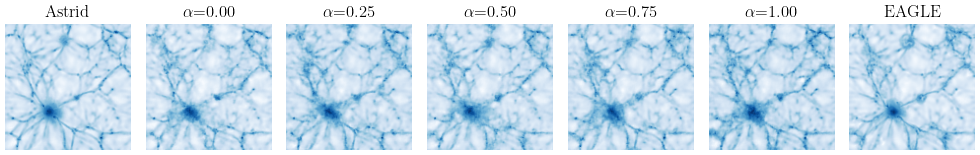

In [33]:
os.environ["PATH"] += ':/mnt/sw/nix/store/2h2mfxgy98zls6ja0czcz087i38v8wx3-texlive-20240312/bin/x86_64-linux'

import importlib
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(interpolation_results)+2, figsize=(10, 4))

_, gas_maps_astrid, _, _, _ = pipeline_CV.loaded_datasets['Astrid']
axes[0].imshow(gas_maps_astrid[astrid_idx][0], cmap='Blues')
axes[0].set_title(f'Astrid')
axes[0].axis('off')

_, gas_maps_eagle, _, _, _ = pipeline_CV.loaded_datasets['EAGLE']
axes[6].imshow(gas_maps_eagle[eagle_idx][0], cmap='Blues')
axes[6].set_title(f'EAGLE')
axes[6].axis('off')

for i, result in enumerate(interpolation_results):
    pred = result['prediction']
    alpha = result['alpha']
    
    # Show middle slice of 3D volume
    axes[i+1].imshow(pred[0], cmap='Blues')
    axes[i+1].set_title(f'$\\alpha$={alpha:.2f}')
    axes[i+1].axis('off')
plt.tight_layout()
plt.show()


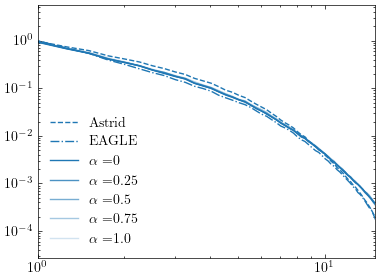

In [47]:
plt.figure(figsize=(4,3))

k,pk = get_pk(gas_maps_astrid[0].astype(np.float32))
plt.loglog(k,pk,ls='--',c='tab:blue',label='Astrid')
k,pk = get_pk(gas_maps_eagle[0].astype(np.float32))
plt.loglog(k,pk,ls='-.',c='tab:blue',label='EAGLE')

for i, result in enumerate(interpolation_results):
    pred = result['prediction']
    alpha = result['alpha']

    k,pk=get_pk(pred)
    plt.loglog(k,pk,c='tab:blue',label=f'$\\alpha=${alpha}',alpha=0.2*(5-i))
    plt.xlim(1,15)

plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

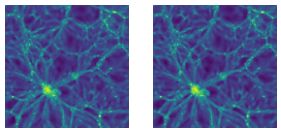

In [87]:
base = '/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/3D_grids/data'
gas_maps_astrid = np.load(f'{base}/Astrid/Grids_Mcdm_Astrid_CV_128_z=0.0.npy',mmap_mode='r')
gas_maps_eagle = np.load(f'/mnt/home/mliu1/CAMELS-cube/Grids_Mcdm_EAGLE_CV_128_z=0.0.npy',mmap_mode='r')

plt.subplot(1,2,1)
plt.imshow(np.log1p(gas_maps_astrid[0][0]))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.log1p(gas_maps_eagle[0][0]))
plt.axis('off')


In [6]:
def interpolate_and_infer(pipeline, embedding_idx1, embedding_idx2, 
                         cdm_mass, cosmo_params, num_steps=100, 
                         alpha_values=None):
    
    if alpha_values is None:
        alpha_values = [0, 0.25, 0.5, 0.75, 1.0]
    
    # Get the combined features matrix
    X_resnet_combined = pipeline.get_combined_features()
    
    if X_resnet_combined is None:
        raise ValueError("No ResNet features found. Make sure extract_embedding() was run with extract_features=True")
    
    # Get the two embeddings to interpolate between
    embedding1 = X_resnet_combined[embedding_idx1]
    embedding2 = X_resnet_combined[embedding_idx2]
    
    print(f"Interpolating between embedding {embedding_idx1} and {embedding_idx2}")
    print(f"Embedding shapes: {embedding1.shape}, {embedding2.shape}")
    
    predictions = []
    
    for alpha in alpha_values:
        print(f"Running inference with alpha = {alpha}")
        
        # Linear interpolation: (1-alpha) * emb1 + alpha * emb2
        interpolated_embedding = (1 - alpha) * embedding1 + alpha * embedding2
        
        # Run inference with interpolated embedding
        pred = pipeline.inference(
            cdm_mass=cdm_mass,
            params=cosmo_params,
            resnet_embed=interpolated_embedding,
            num_steps=num_steps
        )
        
        predictions.append({
            'alpha': alpha,
            'prediction': pred,
            'interpolated_embedding': interpolated_embedding
        })
    
    return predictions

def get_embedding_info(pipeline):

    X_resnet = pipeline.get_combined_features()
    labels = pipeline.get_labels()
    cosmo_params, astro_params = pipeline.get_parameters()
    
    if X_resnet is None:
        return None
    
    # Flatten parameter arrays if needed
    cosmo_flat = np.vstack(cosmo_params) if cosmo_params else None
    astro_flat = np.vstack(astro_params) if astro_params else None
    
    info = {
        'total_embeddings': len(X_resnet),
        'embedding_shape': X_resnet[0].shape,
        'labels': labels,
        'cosmo_params': cosmo_flat,
        'astro_params': astro_flat
    }
    
    # Group by model
    model_indices = {}
    for i, label in enumerate(labels):
        if label not in model_indices:
            model_indices[label] = []
        model_indices[label].append(i)
    
    info['model_indices'] = model_indices
    
    return info

In [7]:
embedding_info = get_embedding_info(pipeline)
print("Available embeddings:")
print(f"Total: {embedding_info['total_embeddings']}")
print(f"Shape: {embedding_info['embedding_shape']}")
print("\nEmbeddings per model:")
for model, indices in embedding_info['model_indices'].items():
    print(f"{model}: {len(indices)} embeddings (indices {indices[0]} to {indices[-1]})")

astrid_idx=42
eagle_idx=42
astrid_abs_idx = embedding_info['model_indices']['Astrid'][astrid_idx]
eagle_abs_idx = embedding_info['model_indices']['EAGLE'][eagle_idx]

print(f"\nSelected embeddings:")
print(f"Astrid embedding: index {astrid_idx}")
print(f"EAGLE embedding: index {eagle_idx}")

model_name = 'Astrid'  # or any model you want
total_mass, star_maps, gas_maps, T_maps, P_maps, cosmo_params, _ = pipeline.loaded_datasets[model_name]
cdm_sample = total_mass[astrid_idx]
cosmo_sample = cosmo_params[astrid_idx]

# 4. Run interpolation and inference
interpolation_results = interpolate_and_infer(
    pipeline=pipeline,
    embedding_idx1=astrid_abs_idx,
    embedding_idx2=eagle_abs_idx,
    cdm_mass=cdm_sample,
    cosmo_params=cosmo_sample,
    num_steps=200,
    alpha_values=[0, 0.25, 0.5, 0.75, 1.0]
)

# 5. Examine results
print(f"\nGenerated {len(interpolation_results)} predictions")
for i, result in enumerate(interpolation_results):
    pred = result['prediction']
    alpha = result['alpha']
    print(f"Alpha {alpha}: prediction shape {pred.shape}")

Available embeddings:
Total: 1620
Shape: (8,)

Embeddings per model:
IllustrisTNG: 405 embeddings (indices 0 to 404)
EAGLE: 405 embeddings (indices 405 to 809)
SIMBA: 405 embeddings (indices 810 to 1214)
Astrid: 405 embeddings (indices 1215 to 1619)

Selected embeddings:
Astrid embedding: index 42
EAGLE embedding: index 42
Interpolating between embedding 1257 and 447
Embedding shapes: (8,), (8,)
Running inference with alpha = 0
Running inference with alpha = 0.25
Running inference with alpha = 0.5
Running inference with alpha = 0.75
Running inference with alpha = 1.0

Generated 5 predictions
Alpha 0: prediction shape (4, 256, 256)
Alpha 0.25: prediction shape (4, 256, 256)
Alpha 0.5: prediction shape (4, 256, 256)
Alpha 0.75: prediction shape (4, 256, 256)
Alpha 1.0: prediction shape (4, 256, 256)


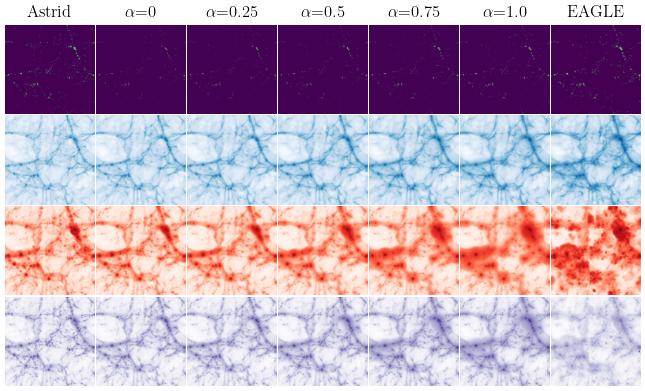

In [11]:
plt.figure(figsize=(8.2,4.7))
plt.subplots_adjust(wspace=0.02, hspace=0.01)
cls = ['viridis','Blues','Reds','Purples']

_, star_maps, gas_maps, T_maps, P_maps, _, _ = pipeline.loaded_datasets['Astrid']
plt.subplot(4,7,1)
plt.imshow(star_maps[astrid_idx],cmap='viridis')
plt.title(f'Astrid')
plt.axis('off')
plt.subplot(4,7,1+7)
plt.imshow(gas_maps[astrid_idx],cmap='Blues')
plt.axis('off')
plt.subplot(4,7,1+7*2)
plt.imshow(T_maps[astrid_idx],cmap='Reds')
plt.axis('off')
plt.subplot(4,7,1+7*3)
plt.imshow(P_maps[astrid_idx],cmap='Purples')
plt.axis('off')

_, star_maps, gas_maps, T_maps, P_maps, _, _ = pipeline.loaded_datasets['EAGLE']
plt.subplot(4,7,7)
plt.imshow(star_maps[eagle_idx],cmap='viridis')
plt.title(f'EAGLE')
plt.axis('off')
plt.subplot(4,7,7+7)
plt.imshow(gas_maps[eagle_idx],cmap='Blues')
plt.axis('off')
plt.subplot(4,7,7+7*2)
plt.imshow(T_maps[eagle_idx],cmap='Reds')
plt.axis('off')
plt.subplot(4,7,7+7*3)
plt.imshow(P_maps[eagle_idx],cmap='Purples')
plt.axis('off')

for i,res in enumerate(interpolation_results):
    for j,(channel,cl) in enumerate(zip(res['prediction'],cls)):
        plt.subplot(4,7,i+j*7+2)
        if j==0:
            a = res['alpha']
            plt.title(f'$\\alpha$={a}')
            plt.axis('off')
        else:
            plt.axis('off')
        plt.imshow(channel,cmap=cl)
# plt.tight_layout()
# plt.savefig('transform.png')
plt.show()


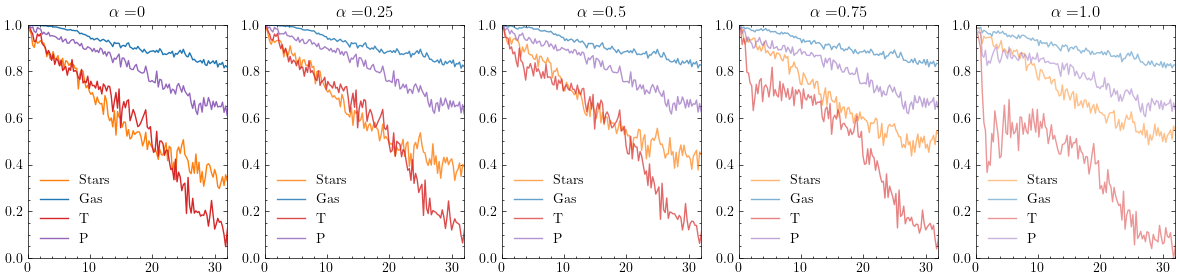

In [80]:
plt.figure(figsize=(12,3))

_, star_maps, gas_maps, T_maps, P_maps, _, _ = pipeline.loaded_datasets['Astrid']
real_astrid = (star_maps[astrid_idx],gas_maps[astrid_idx],T_maps[astrid_idx],P_maps[astrid_idx])

_, star_maps, gas_maps, T_maps, P_maps, _, _ = pipeline.loaded_datasets['EAGLE']
real_eagle = (star_maps[eagle_idx],gas_maps[eagle_idx],T_maps[eagle_idx],P_maps[eagle_idx])

channel_names = [('Stars','tab:orange'),('Gas','tab:blue'),('T','tab:red'),('P','tab:purple')]

for i, intp in enumerate(interpolation_results):
    plt.subplot(1,5,i+1)
    for pred, true, lbl in zip(intp['prediction'],real_astrid,channel_names):
        k,xcor = get_xcorr(pred,true)
        plt.plot(k,xcor,label=lbl[0],color=lbl[1],alpha=1.2**-i)

# for pred, true, lbl in zip(interpolation_results[-1]['prediction'],real_eagle,channel_names):
#     if lbl[0]=='Gas':
#         k,xcor = get_xcorr(pred,true)
#         plt.plot(k,xcor,label='EAGLE '+lbl[0],color=lbl[1],linestyle='--')
    plt.title(f'$\\alpha=${intp['alpha']}')
    plt.xlim(0,32)
    plt.ylim(0,1)
    plt.legend()
plt.tight_layout()
plt.show()

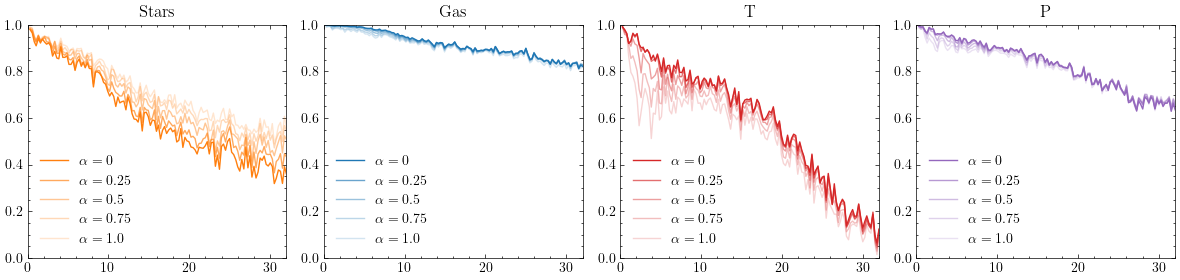

In [8]:
plt.figure(figsize=(12,3))

_, star_maps, gas_maps, T_maps, P_maps, _, _ = pipeline.loaded_datasets['Astrid']
real_astrid = (star_maps[astrid_idx],gas_maps[astrid_idx],T_maps[astrid_idx],P_maps[astrid_idx])

_, star_maps, gas_maps, T_maps, P_maps, _, _ = pipeline.loaded_datasets['EAGLE']
real_eagle = (star_maps[eagle_idx],gas_maps[eagle_idx],T_maps[eagle_idx],P_maps[eagle_idx])

channel_names = [('Stars','tab:orange'),('Gas','tab:blue'),('T','tab:red'),('P','tab:purple')]

for i, intp in enumerate(interpolation_results):
    
    for j,(pred, true_astrid,true_eagle, lbl) in enumerate(zip(intp['prediction'],real_astrid,real_eagle,channel_names)):
        plt.subplot(1,4,j+1)
        k,xcor = get_xcorr(pred,true_astrid)
        plt.plot(k,xcor,label=f'$\\alpha={intp['alpha']}$',color=lbl[1],alpha=1.5**-i)
        # k,xcor = get_xcorr(pred,true_eagle)
        # plt.plot(k,xcor,label=f'$\\alpha={intp['alpha']}$',color=lbl[1],alpha=1.5**-i)

# for pred, true, lbl in zip(interpolation_results[-1]['prediction'],real_eagle,channel_names):
#     if lbl[0]=='Gas':
#         k,xcor = get_xcorr(pred,true)
#         plt.plot(k,xcor,label='EAGLE '+lbl[0],color=lbl[1],linestyle='--')
        plt.legend()
        plt.title(lbl[0])
        plt.xlim(0,32)
        plt.ylim(0.0,1)
plt.tight_layout()
# plt.savefig('corr_sample.png')
plt.show()

/tmp/ipykernel_3658982/1859095981.py:29: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,32)


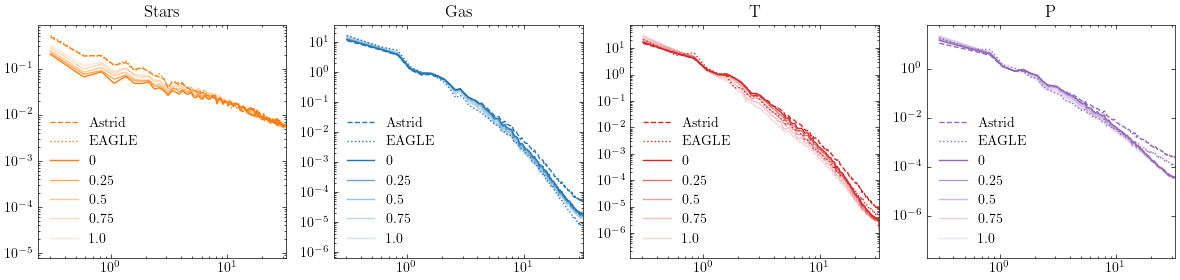

In [10]:
plt.figure(figsize=(12,3))

_, star_maps, gas_maps, T_maps, P_maps, _, _ = pipeline.loaded_datasets['Astrid']
real_astrid = (star_maps[astrid_idx],gas_maps[astrid_idx],T_maps[astrid_idx],P_maps[astrid_idx])

_, star_maps, gas_maps, T_maps, P_maps, _, _ = pipeline.loaded_datasets['EAGLE']
real_eagle = (star_maps[eagle_idx],gas_maps[eagle_idx],T_maps[eagle_idx],P_maps[eagle_idx])

channel_names = [('Stars','tab:orange'),('Gas','tab:blue'),('T','tab:red'),('P','tab:purple')]

for i, intp in enumerate(interpolation_results):
    
    for j,(pred, true_astrid,true_eagle, lbl) in enumerate(zip(intp['prediction'],real_astrid,real_eagle,channel_names)):
        plt.subplot(1,4,j+1)
        if i==0:
            k,pk = get_pk(true_astrid)
            plt.loglog(k,pk,label='Astrid',color=lbl[1],alpha=1,linestyle='--')
            k,pk = get_pk(true_eagle)
            plt.loglog(k,pk,label='EAGLE',color=lbl[1],alpha=1,linestyle=':')
        k,pk = get_pk(pred)
        plt.loglog(k,pk,label=intp['alpha'],color=lbl[1],alpha=1.5**-i)

# for pred, true, lbl in zip(interpolation_results[-1]['prediction'],real_eagle,channel_names):
#     if lbl[0]=='Gas':
#         k,xcor = get_xcorr(pred,true)
#         plt.plot(k,xcor,label='EAGLE '+lbl[0],color=lbl[1],linestyle='--')
        plt.legend()
        plt.title(lbl[0])
        plt.xlim(0,32)
plt.tight_layout()
plt.savefig('pk_sample.png')
plt.show()

In [11]:
# tSNE
all_labels_1P = pipeline.get_labels()
all_labels_LH = pipeline_LH.get_labels()
all_labels_resnet=np.append(all_labels_1P,all_labels_LH)

reducer = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, verbose=False)
embedding_tsne_indv = reducer.fit_transform(np.append(X_resnet_indv,X_resnet_LH,axis=0))

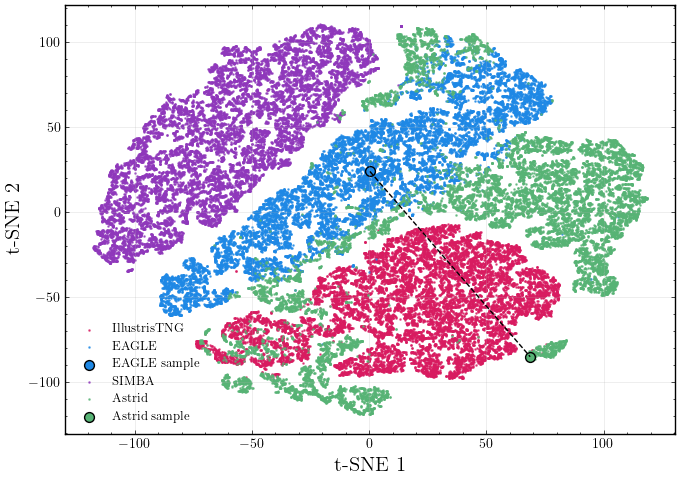

Visualization saved. Total samples: 61620


In [13]:
plt.figure(figsize=(7, 5))
colors = ['#D81B60','#1E88E5','#8F38BB','#57B375','#FFC107']
linex, liney = [],[]
# colors = ['#E74C3C', '#3498DB', '#27AE60', '#9B59B6', '#F39C12']

for i, model_name in enumerate(simulation_models):
    mask = [label == model_name for label in all_labels_resnet]
    plt.scatter(embedding_tsne_indv[mask, 0], embedding_tsne_indv[mask, 1], marker='x' if model_name=='Magneticum' else '.',
               c=colors[i], label='Magneticum (test)' if model_name=='Magneticum' else model_name, alpha=1 if model_name=='Magneticum' else 0.7, s=20 if model_name=='Magneticum' else 3)

    if model_name=='Astrid' or model_name=='EAGLE':
        idx=astrid_idx if model_name=='Astrid' else eagle_idx
        plt.scatter(embedding_tsne_indv[mask, 0][idx], embedding_tsne_indv[mask, 1][idx], marker='o',
                    c=colors[i],edgecolor='black', alpha=1, s=50, 
                    label='Astrid sample' if model_name=='Astrid' else 'EAGLE sample')
        linex.append(embedding_tsne_indv[mask, 0][idx])
        liney.append(embedding_tsne_indv[mask, 1][idx])

plt.plot(linex,liney,linestyle='--',c='black')
plt.xlabel('t-SNE 1',fontsize=15)
plt.ylabel('t-SNE 2',fontsize=15)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
# Make the frame thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(1)
plt.tight_layout()
plt.savefig("tsne_resnet_INTER.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"Visualization saved. Total samples: {len(embedding_tsne_indv)}")

Highlights model sets in latent space, want CV to stick together

In [7]:
# checkpoint_path = 'lightning_logs/newnew/checkpoints/best-model-epoch=143-val_loss=0.026560.ckpt'
checkpoint_path = 'lightning_logs/newnewnew/checkpoints/best-model-epoch=458-val_loss=0.024681.ckpt'
simulation_models = ['IllustrisTNG', 'EAGLE', 'SIMBA', 'Astrid']

pipeline_LH = AnalysisPipeline(checkpoint_path)
X_resnet_LH = pipeline_LH.extract_embedding(simulation_models, dataset='LH', n_samples=5000)

pipeline_CV = AnalysisPipeline(checkpoint_path)
X_resnet_CV = pipeline_CV.extract_embedding(simulation_models, dataset='CV', n_samples=5000)

pipeline_1P = AnalysisPipeline(checkpoint_path)
X_resnet_1P = pipeline_1P.extract_embedding(simulation_models, dataset='1P', n_samples=5000)

Processing simulation models...
Processing IllustrisTNG, 5000 samples...
Processing EAGLE, 5000 samples...
Processing SIMBA, 5000 samples...
Processing Astrid, 5000 samples...
Completed processing 4 models
Total extracted features: (20000, 8)
Processing simulation models...
Processing IllustrisTNG, 405 samples...
Processing EAGLE, 405 samples...
Processing SIMBA, 405 samples...
Processing Astrid, 405 samples...
Completed processing 4 models
Total extracted features: (1620, 8)
Processing simulation models...
Processing IllustrisTNG, 2100 samples...
Processing EAGLE, 450 samples...
Processing SIMBA, 2100 samples...
Processing Astrid, 525 samples...
Completed processing 4 models
Total extracted features: (5175, 8)


In [8]:
# tSNE
sim_labels_1P = pipeline_1P.get_labels()
sim_labels_LH = pipeline_LH.get_labels()
sim_labels_CV = pipeline_CV.get_labels()

set_labels_1P = np.repeat('1P',len(sim_labels_1P))
set_labels_LH = np.repeat('LH',len(sim_labels_LH))
set_labels_CV = np.repeat('CV',len(sim_labels_CV))


sim_labels_all=np.append(sim_labels_1P,np.append(sim_labels_LH,sim_labels_CV))
set_labels_all=np.append(set_labels_1P,np.append(set_labels_LH,set_labels_CV))

reducer = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, verbose=False)
embedding_tsne_indv = reducer.fit_transform(np.append(X_resnet_1P,np.append(X_resnet_LH,X_resnet_CV,axis=0),axis=0))

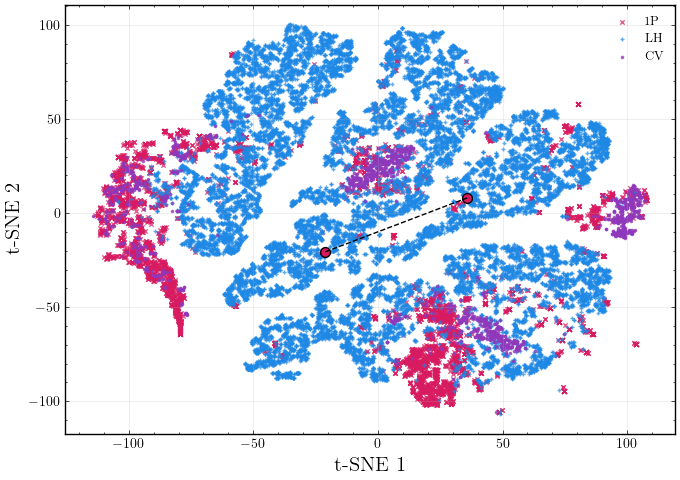

Visualization saved. Total samples: 26795


In [21]:
plt.figure(figsize=(7, 5))
colors = ['#D81B60','#1E88E5','#8F38BB','#57B375','#FFC107']
linex, liney = [],[]
# colors = ['#E74C3C', '#3498DB', '#27AE60', '#9B59B6', '#F39C12']

set_names = ['1P','LH','CV']
markers = ['x','+','.']
linex,liney = [],[]
idx=10

for i, model_name in enumerate(simulation_models):
    mask_sim = np.array([label == model_name for label in sim_labels_all])
    for j, set_name in enumerate(set_names):
        mask_set = np.array([label == set_name for label in set_labels_all])
        mask = np.logical_and(mask_sim,mask_set)
        plt.scatter(embedding_tsne_indv[mask, 0], embedding_tsne_indv[mask, 1], marker=markers[j],
                   c=colors[j], label=set_name if i==0 else None, alpha=0.7, s=10)

        if set_name=='1P' and model_name in ['Astrid','EAGLE']:
            idx=23 if model_name=='Astrid' else 16
            linex.append(embedding_tsne_indv[mask, 0][idx])
            liney.append(embedding_tsne_indv[mask, 1][idx])

plt.scatter(linex[0], liney[0], marker='o', c=colors[0],edgecolor='black', alpha=1, s=50)
plt.scatter(linex[1], liney[1], marker='o', c=colors[0],edgecolor='black', alpha=1, s=50)
plt.plot(linex,liney,linestyle='--',c='black')
plt.xlabel('t-SNE 1',fontsize=15)
plt.ylabel('t-SNE 2',fontsize=15)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
# Make the frame thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(1)
plt.tight_layout()
# plt.savefig("tsne_resnet_sets.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"Visualization saved. Total samples: {len(embedding_tsne_indv)}")

In [10]:
checkpoint_path = 'lightning_logs/newnewnew/checkpoints/best-model-epoch=458-val_loss=0.024681.ckpt'
simulation_models = ['IllustrisTNG', 'EAGLE', 'SIMBA', 'Astrid']

pipeline_LH = AnalysisPipeline(checkpoint_path)
X_resnet_LH = pipeline_LH.extract_embedding(simulation_models, dataset='LH', n_samples=5000)

Processing simulation models...
Processing IllustrisTNG, 5000 samples...
Processing EAGLE, 5000 samples...
Processing SIMBA, 5000 samples...
Processing Astrid, 5000 samples...
Completed processing 4 models
Total extracted features: (20000, 8)


In [21]:
total_value = []

for key in pipeline_LH.loaded_datasets.keys():
    value = []
    for img in pipeline_LH.loaded_datasets[key][0]:
        value.append(np.percentile(np.asarray(img),90))
    total_value.append(value)

total_value = np.asarray(total_value).flatten()

In [23]:
# tSNE
sim_labels_LH = pipeline_LH.get_labels()
set_labels_LH = np.repeat('LH',len(sim_labels_LH))
reducer = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, verbose=False)
embedding_tsne_indv = reducer.fit_transform(X_resnet_LH)

In [25]:
cosmo_params,_ = pipeline_LH.get_parameters()

In [30]:
Omega_m = np.asarray(cosmo_params)[:,:,0].flatten()

/tmp/ipykernel_2242369/3943189600.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=9)


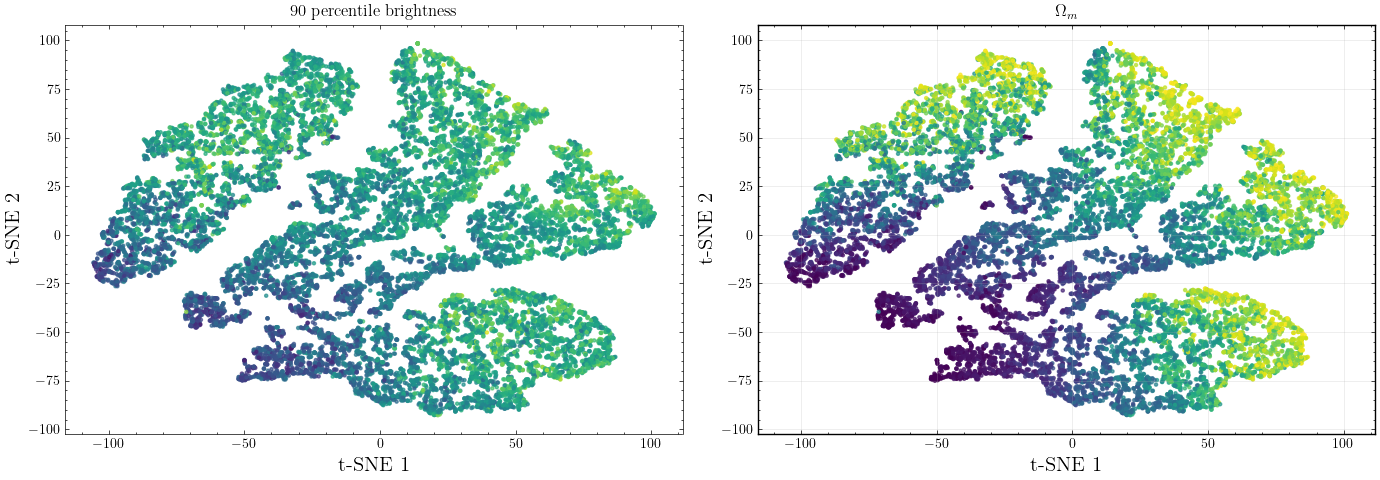

Visualization saved. Total samples: 20000


In [32]:
plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
plt.scatter(embedding_tsne_indv[:, 0], embedding_tsne_indv[:, 1], c=total_value, alpha=0.7, s=5)
plt.xlabel('t-SNE 1',fontsize=15)
plt.ylabel('t-SNE 2',fontsize=15)
plt.title('90 percentile brightness')

plt.subplot(1,2,2)
plt.scatter(embedding_tsne_indv[:, 0], embedding_tsne_indv[:, 1], c=Omega_m, alpha=0.7, s=5)
plt.xlabel('t-SNE 1',fontsize=15)
plt.ylabel('t-SNE 2',fontsize=15)
plt.title('$\\Omega_m$')

plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
# Make the frame thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(1)
plt.tight_layout()
plt.savefig("tsne_resnet_90.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"Visualization saved. Total samples: {len(embedding_tsne_indv)}")